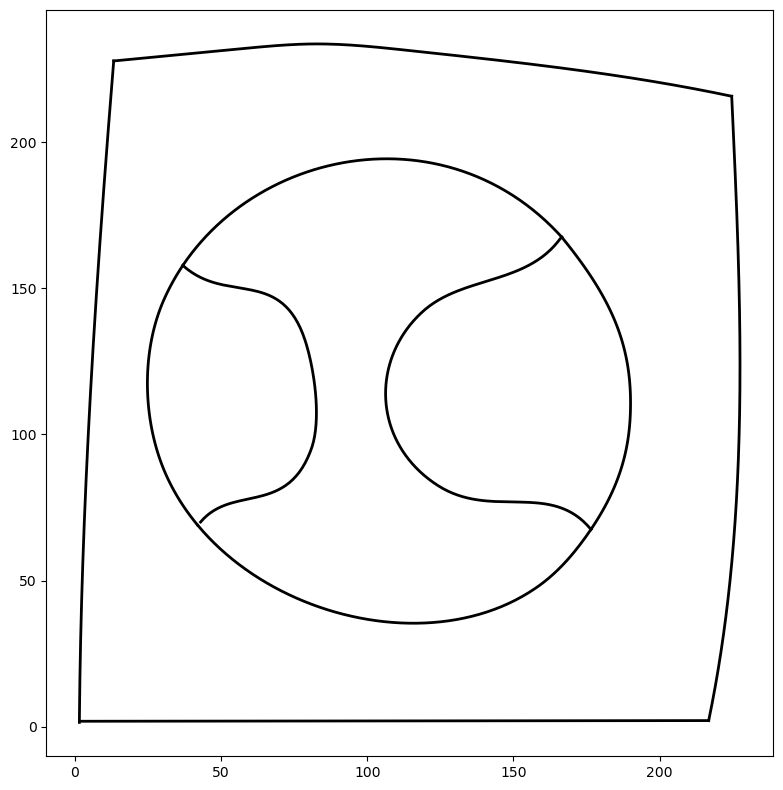

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define a list of colors
colours = ['Black']
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Use the functions
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv"
paths_XYs = read_csv(csv_path)
plot(paths_XYs)

In [12]:
from scipy.interpolate import splprep, splev

def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

def calculate_properties(polyline):
    # Calculate length
    diffs = np.diff(polyline, axis=0)
    length = np.sum(np.sqrt(np.sum(diffs**2, axis=1)))
    
    # Calculate curvature
    dx_dt = np.gradient(polyline[:, 0])
    dy_dt = np.gradient(polyline[:, 1])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    
    return length, np.mean(curvature)

# Process each polyline
processed_paths = []
for path in paths_XYs:
    processed_path = []
    for polyline in path:
        simplified = simplify_polyline(polyline)
        length, avg_curvature = calculate_properties(simplified)
        processed_path.append({
            'points': simplified,
            'length': length,
            'avg_curvature': avg_curvature
        })
    processed_paths.append(processed_path)

In [13]:
def is_straight_line(polyline, curvature_threshold=0.01):
    return polyline['avg_curvature'] < curvature_threshold

straight_lines = []
for path in processed_paths:
    for polyline in path:
        if is_straight_line(polyline):
            straight_lines.append(polyline)

In [15]:
from scipy import optimize

def ellipse(x, y, x0, y0, a, b, theta):
    x_r = (x - x0) * np.cos(theta) + (y - y0) * np.sin(theta)
    y_r = -(x - x0) * np.sin(theta) + (y - y0) * np.cos(theta)
    return (x_r / a)**2 + (y_r / b)**2 - 1

def fit_ellipse(x, y):
    def fit_func(params):
        return ellipse(x, y, *params)

    p0 = [np.mean(x), np.mean(y), np.std(x), np.std(y), 0]
    params, _ = optimize.leastsq(fit_func, p0)
    return params

def is_circle_or_ellipse(polyline, threshold=0.1):
    x, y = polyline['points'][:, 0], polyline['points'][:, 1]
    params = fit_ellipse(x, y)
    residuals = np.abs(ellipse(x, y, *params))
    return np.mean(residuals) < threshold

circles_and_ellipses = []
for path in processed_paths:
    for polyline in path:
        if is_circle_or_ellipse(polyline):
            circles_and_ellipses.append(polyline)

C:\Users\Welcome\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:494: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


In [16]:
from scipy import optimize

def fit_ellipse(x, y):
    def fit_func(params):
        return ellipse(x, y, *params)

    # Improve initial guess
    x_center = np.mean(x)
    y_center = np.mean(y)
    a = np.max(x) - np.min(x)
    b = np.max(y) - np.min(y)
    if a < b:
        a, b = b, a
    p0 = [x_center, y_center, a/2, b/2, 0]

    # Use different optimization method with bounds
    bounds = [(None, None), (None, None), (0, None), (0, None), (-np.pi, np.pi)]
    result = optimize.least_squares(fit_func, p0, bounds=bounds, method='trf')
    
    return result.x

def is_circle_or_ellipse(polyline, threshold=0.1):
    x, y = polyline['points'][:, 0], polyline['points'][:, 1]
    try:
        params = fit_ellipse(x, y)
        residuals = np.abs(ellipse(x, y, *params))
        return np.mean(residuals) < threshold
    except:
        return False  # If fitting fails, assume it's not an ellipse

In [17]:
def is_regular_polygon(polyline, num_sides, angle_tolerance=0.1, length_tolerance=0.1):
    points = polyline['points']
    sides = np.roll(points, -1, axis=0) - points
    side_lengths = np.sqrt(np.sum(sides**2, axis=1))
    angles = np.arctan2(sides[:, 1], sides[:, 0])
    angle_diffs = np.abs(np.diff(angles))
    
    expected_angle = 2 * np.pi / num_sides
    is_angle_regular = np.all(np.abs(angle_diffs - expected_angle) < angle_tolerance)
    is_length_regular = np.std(side_lengths) / np.mean(side_lengths) < length_tolerance
    
    return is_angle_regular and is_length_regular

rectangles = []
regular_polygons = {3: [], 5: [], 6: [], 8: []}

for path in processed_paths:
    for polyline in path:
        if is_regular_polygon(polyline, 4):
            rectangles.append(polyline)
        for sides in [3, 5, 6, 8]:
            if is_regular_polygon(polyline, sides):
                regular_polygons[sides].append(polyline)

In [18]:
def is_star_shape(polyline, num_points=5, ratio_threshold=0.5):
    points = polyline['points']
    center = np.mean(points, axis=0)
    distances = np.sqrt(np.sum((points - center)**2, axis=1))
    
    if len(distances) < 2 * num_points:
        return False
    
    peaks = distances[::2]
    valleys = distances[1::2]
    ratio = np.mean(valleys) / np.mean(peaks)
    
    return ratio < ratio_threshold

star_shapes = []
for path in processed_paths:
    for polyline in path:
        if is_star_shape(polyline):
            star_shapes.append(polyline)

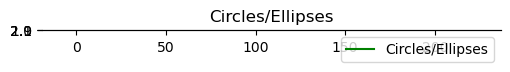

In [21]:
import matplotlib.pyplot as plt

def plot_regularized_shapes(shapes_dict):
    num_shapes = len(shapes_dict)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_shapes + num_cols - 1) // num_cols  # Calculate required rows
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.ravel()

    # Define color map for different shapes
    colors = {
        'Straight Lines': 'blue',
        'Circles/Ellipses': 'green',
        'Rectangles': 'red',
        'Triangles': 'purple',
        'Pentagons': 'orange',
        'Stars': 'magenta'
    }

    for i, (shape_type, shapes) in enumerate(shapes_dict.items()):
        ax = axs[i]
        if not shapes:  # Skip empty shape categories
            ax.set_visible(False)
            continue

        for shape in shapes:
            points = shape['points']
            ax.plot(points[:, 0], points[:, 1], label=shape_type, color=colors.get(shape_type, 'black'))
        
        ax.set_title(shape_type)
        ax.set_aspect('equal')
        ax.grid(True)
        ax.legend()

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# Define the shape categories
regularized_shapes = {
    'Straight Lines': straight_lines,
    'Circles/Ellipses': circles_and_ellipses,
    'Rectangles': rectangles,
    'Triangles': regular_polygons.get(3, []),
    'Pentagons': regular_polygons.get(5, []),
    'Stars': star_shapes
}

# Call the function to plot
plot_regularized_shapes(regularized_shapes)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

In [2]:
# Define colors for plotting
colours = ['Black']

In [3]:
# Read CSV function
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [4]:
# Plot function
def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()


In [5]:
# Simplify Polyline function
def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

In [6]:
# Check if the polyline is a straight line
def is_straight_line(polyline, curvature_threshold=0.01):
    dx_dt = np.gradient(polyline[:, 0])
    dy_dt = np.gradient(polyline[:, 1])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    return np.mean(curvature) < curvature_threshold

In [7]:
# Fit ellipse function
def fit_ellipse(x, y):
    def ellipse(x, y, x0, y0, a, b, theta):
        x_r = (x - x0) * np.cos(theta) + (y - y0) * np.sin(theta)
        y_r = -(x - x0) * np.sin(theta) + (y - y0) * np.cos(theta)
        return (x_r / a)**2 + (y_r / b)**2 - 1

In [11]:
   def fit_func(params):
        return ellipse(x, y, *params)

    x_center = np.mean(x)
    y_center = np.mean(y)
    a = np.max(x) - np.min(x)
    b = np.max(y) - np.min(y)
    if a < b:
        a, b = b, a
    p0 = [x_center, y_center, a/2, b/2, 0]
    bounds = [(None, None), (None, None), (0, None), (0, None), (-np.pi, np.pi)]
    result = optimize.least_squares(fit_func, p0, bounds=bounds, method='trf')
    
    return result.x

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)

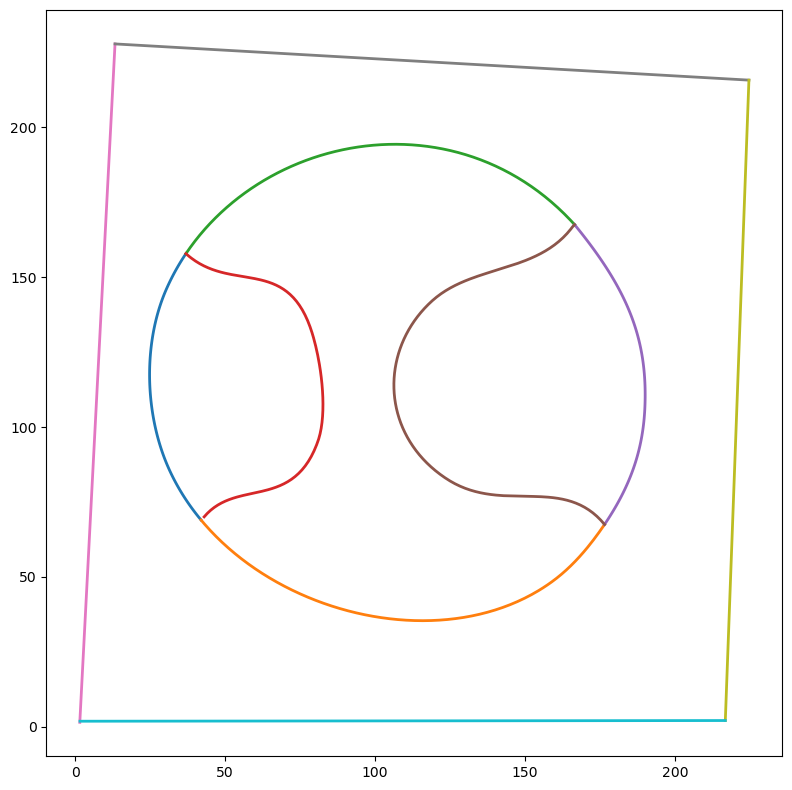

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

# Define colors for plotting
colours = ['Black']

# Read CSV function
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Plot function
def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Simplify Polyline function
def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

# Check if the polyline is a straight line
def is_straight_line(polyline, curvature_threshold=0.01):
    dx_dt = np.gradient(polyline[:, 0])
    dy_dt = np.gradient(polyline[:, 1])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    return np.mean(curvature) < curvature_threshold

# Fit ellipse function
def fit_ellipse(x, y):
    def ellipse(x, y, x0, y0, a, b, theta):
        x_r = (x - x0) * np.cos(theta) + (y - y0) * np.sin(theta)
        y_r = -(x - x0) * np.sin(theta) + (y - y0) * np.cos(theta)
        return (x_r / a)**2 + (y_r / b)**2 - 1

    def fit_func(params):
        return ellipse(x, y, *params)

    x_center = np.mean(x)
    y_center = np.mean(y)
    a = np.max(x) - np.min(x)
    b = np.max(y) - np.min(y)
    if a < b:
        a, b = b, a
    p0 = [x_center, y_center, a/2, b/2, 0]
    bounds = [(None, None), (None, None), (0, None), (0, None), (-np.pi, np.pi)]
    result = optimize.least_squares(fit_func, p0, bounds=bounds, method='trf')
    
    return result.x

# Check if the polyline is a circle or ellipse
def is_circle_or_ellipse(polyline, threshold=0.1):
    x, y = polyline[:, 0], polyline[:, 1]
    try:
        params = fit_ellipse(x, y)
        residuals = np.abs(ellipse(x, y, *params))
        return np.mean(residuals) < threshold
    except:
        return False

# Bézier conversion for line
def bezier_line(start, end):
    return np.array([start, start * 2/3 + end * 1/3, start * 1/3 + end * 2/3, end])

# Bézier conversion for ellipse
def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2*np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    
    return np.column_stack((x, y))

# Function to convert detected shapes to Bézier curves
def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        return bezier_line(polyline[0], polyline[-1])
    elif is_circle_or_ellipse(polyline):
        params = fit_ellipse(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    else:
        # For now, return the simplified polyline itself
        return polyline

# Plot Bézier curves
def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for bezier_curve in bezier_curves:
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Main Execution
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv"
paths_XYs = read_csv(csv_path)

bezier_curves = []
for path in paths_XYs:
    for polyline in path:
        bezier_curve = convert_to_bezier(polyline)
        bezier_curves.append(bezier_curve)

plot_bezier(bezier_curves)


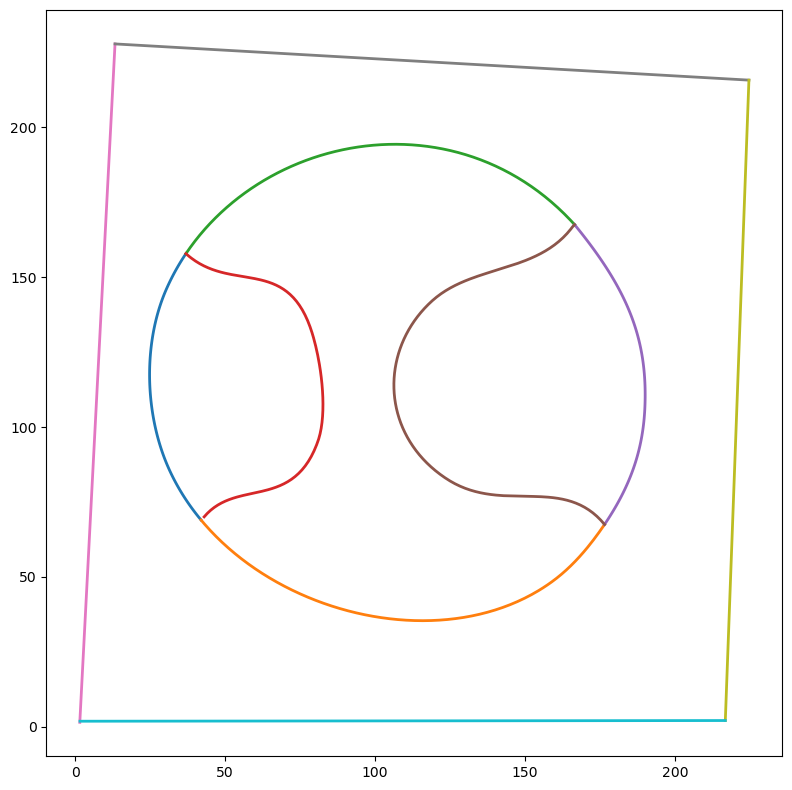

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

# Define colors for plotting
COLORS = ['Black']

# Read CSV data
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = [npXYs[npXYs[:, 0] == j][:, 1:] for j in np.unique(npXYs[:, 0])]
        path_XYs.append(XYs)
    return path_XYs

# Plot functions
def plot(paths_XYs, colors=COLORS):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Simplify Polyline
def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

# Determine if a polyline is a straight line
def is_straight_line(polyline, curvature_threshold=0.01):
    dx_dt = np.gradient(polyline[:, 0])
    dy_dt = np.gradient(polyline[:, 1])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    return np.mean(curvature) < curvature_threshold

# Fit ellipse to points
def fit_ellipse(x, y):
    def ellipse(x, y, x0, y0, a, b, theta):
        x_r = (x - x0) * np.cos(theta) + (y - y0) * np.sin(theta)
        y_r = -(x - x0) * np.sin(theta) + (y - y0) * np.cos(theta)
        return (x_r / a)**2 + (y_r / b)**2 - 1

    def fit_func(params):
        return ellipse(x, y, *params)

    x_center = np.mean(x)
    y_center = np.mean(y)
    a = np.max(x) - np.min(x)
    b = np.max(y) - np.min(y)
    if a < b:
        a, b = b, a
    p0 = [x_center, y_center, a / 2, b / 2, 0]
    bounds = [(None, None), (None, None), (0, None), (0, None), (-np.pi, np.pi)]
    result = optimize.least_squares(fit_func, p0, bounds=bounds, method='trf')
    
    return result.x

# Check if a polyline is a circle or ellipse
def is_circle_or_ellipse(polyline, threshold=0.1):
    x, y = polyline[:, 0], polyline[:, 1]
    try:
        params = fit_ellipse(x, y)
        residuals = np.abs(ellipse(x, y, *params))
        return np.mean(residuals) < threshold
    except:
        return False

# Convert detected shapes to Bézier curves
def bezier_line(start, end):
    return np.array([start, start * 2/3 + end * 1/3, start * 1/3 + end * 2/3, end])

def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    
    return np.column_stack((x, y))

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        return bezier_line(polyline[0], polyline[-1])
    elif is_circle_or_ellipse(polyline):
        params = fit_ellipse(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    else:
        # For now, return the simplified polyline itself
        return polyline

def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for bezier_curve in bezier_curves:
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Main Execution
def main(csv_path):
    paths_XYs = read_csv(csv_path)
    bezier_curves = [convert_to_bezier(polyline) for path in paths_XYs for polyline in path]
    plot_bezier(bezier_curves)

# Example usage
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv"
main(csv_path)


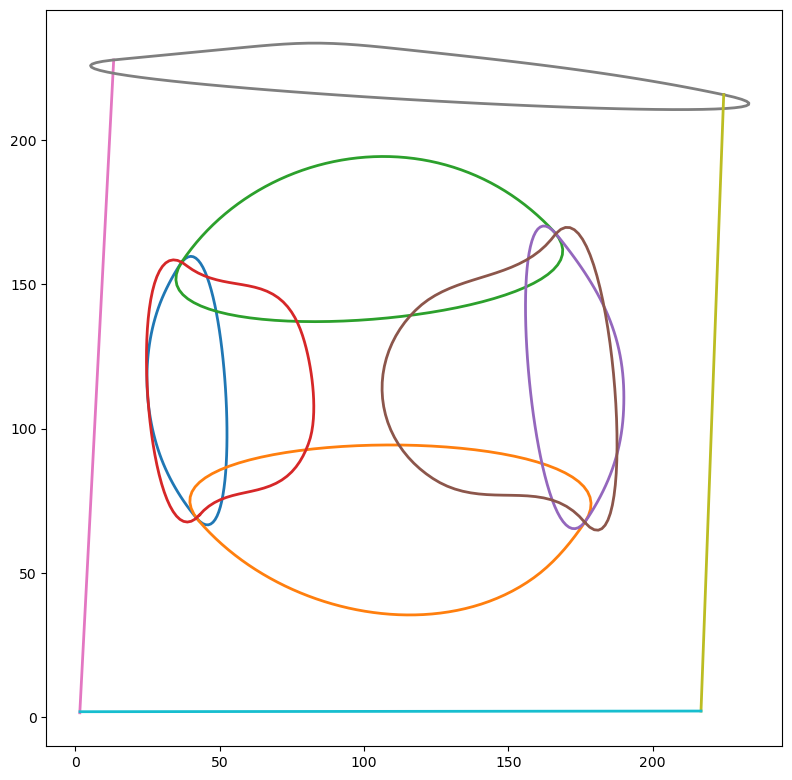

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

# Define colors for plotting
COLORS = ['Black']

# Read CSV data
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = [npXYs[npXYs[:, 0] == j][:, 1:] for j in np.unique(npXYs[:, 0])]
        path_XYs.append(XYs)
    return path_XYs

# Plot functions
def plot(paths_XYs, colors=COLORS):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Simplify Polyline
def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

# Determine if a polyline is a straight line using angles between segments
def is_straight_line(polyline, angle_threshold=0.1):
    vectors = np.diff(polyline, axis=0)
    angles = np.arctan2(vectors[:, 1], vectors[:, 0])
    return np.std(angles) < angle_threshold

# Fit ellipse to points
def fit_ellipse(x, y):
    def ellipse(x, y, x0, y0, a, b, theta):
        x_r = (x - x0) * np.cos(theta) + (y - y0) * np.sin(theta)
        y_r = -(x - x0) * np.sin(theta) + (y - y0) * np.cos(theta)
        return (x_r / a)**2 + (y_r / b)**2 - 1

    def fit_func(params):
        return ellipse(x, y, *params)

    x_center = np.mean(x)
    y_center = np.mean(y)
    a = np.max(x) - np.min(x)
    b = np.max(y) - np.min(y)
    if a < b:
        a, b = b, a
    p0 = [x_center, y_center, a / 2, b / 2, 0]
    bounds = [(None, None), (None, None), (0, None), (0, None), (-np.pi, np.pi)]
    result = optimize.least_squares(fit_func, p0, bounds=bounds, method='trf')
    
    return result.x

# Check if a polyline is a circle or ellipse
def is_circle_or_ellipse(polyline, threshold=0.1):
    x, y = polyline[:, 0], polyline[:, 1]
    try:
        params = fit_ellipse(x, y)
        residuals = np.abs(ellipse(x, y, *params))
        return np.mean(residuals) < threshold
    except:
        return False

# Convert detected shapes to Bézier curves
def bezier_line(start, end):
    return np.array([start, start * 2/3 + end * 1/3, start * 1/3 + end * 2/3, end])

def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    
    return np.column_stack((x, y))

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        return bezier_line(polyline[0], polyline[-1])
    elif is_circle_or_ellipse(polyline):
        params = fit_ellipse(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    else:
        # For now, return the simplified polyline itself
        return simplify_polyline(polyline)

def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for bezier_curve in bezier_curves:
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Main Execution
def main(csv_path):
    paths_XYs = read_csv(csv_path)
    bezier_curves = [convert_to_bezier(polyline) for path in paths_XYs for polyline in path]
    plot_bezier(bezier_curves)

# Example usage
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv"
main(csv_path)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

# Define colors for plotting
COLORS = ['Black']

# Read CSV data
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = [npXYs[npXYs[:, 0] == j][:, 1:] for j in np.unique(npXYs[:, 0])]
        path_XYs.append(XYs)
    return path_XYs

# Plot functions
def plot(paths_XYs, colors=COLORS):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Determine if a polyline is a straight line
def is_straight_line(polyline, tolerance=1e-6):
    # Fit a line to the polyline
    A = np.vstack([polyline[:, 0], np.ones(len(polyline))]).T
    m, c = np.linalg.lstsq(A, polyline[:, 1], rcond=None)[0]
    
    # Calculate the difference between the actual points and the fitted line
    fit_line = m * polyline[:, 0] + c
    residuals = np.abs(polyline[:, 1] - fit_line)
    
    # Check if residuals are within the tolerance for straightness
    return np.all(residuals < tolerance)

# Function to convert detected shapes to Bézier curves
def bezier_line(start, end):
    return np.array([start, start * 2/3 + end * 1/3, start * 1/3 + end * 2/3, end])

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        return polyline  # No conversion for straight lines
    else:
        return simplify_polyline(polyline)

# Simplify Polyline (for curves)
def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
   


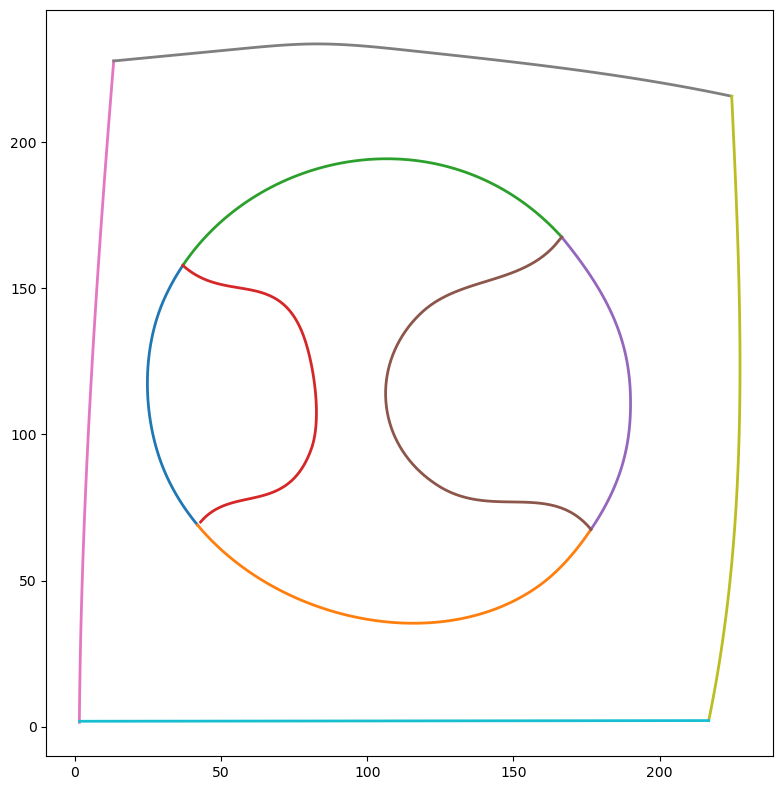

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

# Define colors for plotting
COLORS = ['Black']

# Read CSV data
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = [npXYs[npXYs[:, 0] == j][:, 1:] for j in np.unique(npXYs[:, 0])]
        path_XYs.append(XYs)
    return path_XYs

# Plot functions
def plot(paths_XYs, colors=COLORS):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Determine if a polyline is a straight line
def is_straight_line(polyline, tolerance=1e-6):
    # Fit a line to the polyline
    A = np.vstack([polyline[:, 0], np.ones(len(polyline))]).T
    m, c = np.linalg.lstsq(A, polyline[:, 1], rcond=None)[0]
    
    # Calculate the difference between the actual points and the fitted line
    fit_line = m * polyline[:, 0] + c
    residuals = np.abs(polyline[:, 1] - fit_line)
    
    # Check if residuals are within the tolerance for straightness
    return np.all(residuals < tolerance)

# Function to convert detected shapes to Bézier curves
def bezier_line(start, end):
    return np.array([start, start * 2/3 + end * 1/3, start * 1/3 + end * 2/3, end])

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        return polyline  # No conversion for straight lines
    else:
        return simplify_polyline(polyline)

# Simplify Polyline (for curves)
def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for bezier_curve in bezier_curves:
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Main Execution
def main(csv_path):
    paths_XYs = read_csv(csv_path)
    bezier_curves = [convert_to_bezier(polyline) for path in paths_XYs for polyline in path]
    plot_bezier(bezier_curves)

# Example usage
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv"
main(csv_path)


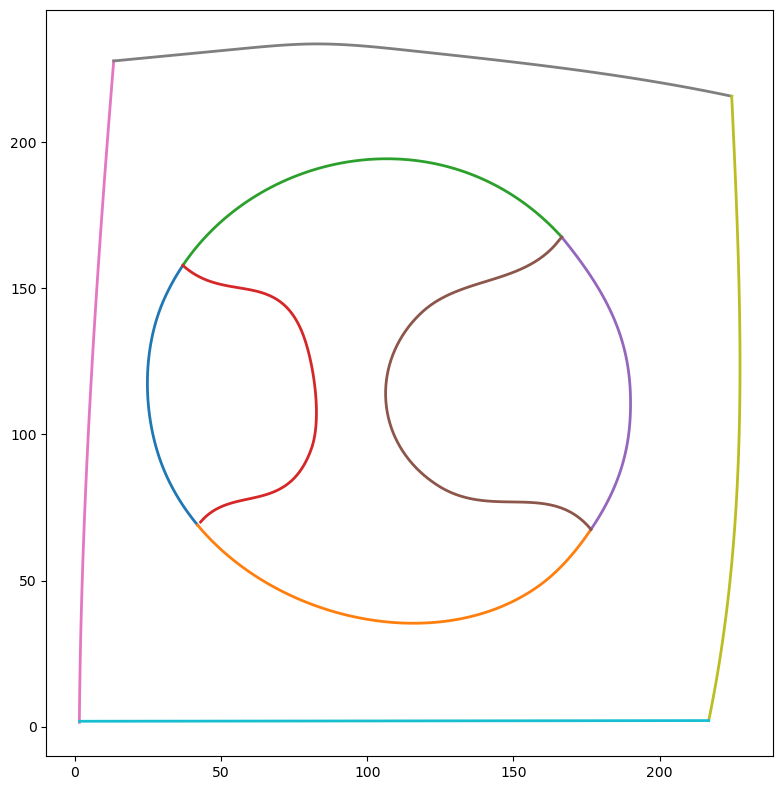

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Define colors for plotting
COLORS = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'yellow']

# Read CSV data
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = [npXYs[npXYs[:, 0] == j][:, 1:] for j in np.unique(npXYs[:, 0])]
        path_XYs.append(XYs)
    return path_XYs

# Plot functions
def plot(paths_XYs, colors=COLORS):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Determine if a polyline is a straight line
def is_straight_line(polyline, tolerance=1e-5):
    if len(polyline) < 3:
        return True  # Treat lines with 2 points as straight
    # Fit a line to the polyline
    A = np.vstack([polyline[:, 0], np.ones(len(polyline))]).T
    m, c = np.linalg.lstsq(A, polyline[:, 1], rcond=None)[0]
    
    # Calculate the difference between the actual points and the fitted line
    fit_line = m * polyline[:, 0] + c
    residuals = np.abs(polyline[:, 1] - fit_line)
    
    # Check if residuals are within the tolerance for straightness
    return np.all(residuals < tolerance)

# Function to convert detected shapes to Bézier curves
def bezier_line(start, end):
    return np.array([start, start * 2/3 + end * 1/3, start * 1/3 + end * 2/3, end])

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        return polyline  # No conversion for straight lines
    else:
        return simplify_polyline(polyline)

# Simplify Polyline (for curves)
def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for bezier_curve in bezier_curves:
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Main Execution
def main(csv_path):
    paths_XYs = read_csv(csv_path)
    bezier_curves = [convert_to_bezier(polyline) for path in paths_XYs for polyline in path]
    plot_bezier(bezier_curves)

# Example usage
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv"
main(csv_path)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

# Define colors for plotting
COLORS = ['Black']

# Read CSV data
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = [npXYs[npXYs[:, 0] == j][:, 1:] for j in np.unique(npXYs[:, 0])]
        path_XYs.append(XYs)
    return path_XYs

# Plot functions
def plot(paths_XYs, colors=COLORS):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Simplify Polyline
def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

# Determine if a polyline is a straight line
def is_straight_line(polyline, curvature_threshold=0.01):
    dx_dt = np.gradient(polyline[:, 0])
    dy_dt = np.gradient(polyline[:, 1])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    return np.mean(curvature) < curvature_threshold

# Fit ellipse to points
def fit_ellipse(x, y):
    def ellipse(x, y, x0, y0, a, b, theta):
        x_r = (x - x0) * np.cos(theta) + (y - y0) * np.sin(theta)
        y_r = -(x - x0) * np.sin(theta) + (y - y0) * np.cos(theta)
        return (x_r / a)**2 + (y_r / b)**2 - 1

    def fit_func(params):
        return ellipse(x, y, *params)

    x_center = np.mean(x)
    y_center = np.mean(y)
    a = np.max(x) - np.min(x)
    b = np.max(y) - np.min(y)
    if a < b:
        a, b = b, a
    p0 = [x_center, y_center, a / 2, b / 2, 0]
    bounds = [(None, None), (None, None), (0, None), (0, None), (-np.pi, np.pi)]
    result = optimize.least_squares(fit_func, p0, bounds=bounds, method='trf')
    
    return result.x

# Check if a polyline is a circle or ellipse
def is_circle_or_ellipse(polyline, threshold=0.1):
    x, y = polyline[:, 0], polyline[:, 1]
    try:
        params = fit_ellipse(x, y)
        residuals = np.abs(ellipse(x, y, *params))
        return np.mean(residuals) < threshold
    except:
        return False

# Convert detected shapes to Bézier curves
def bezier_line(start, end):
    return np.array([start, start * 2/3 + end * 1/3, start * 1/3 + end * 2/3, end])

def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    
    return np.column_stack((x, y))

# Convert detected shapes to cubic Bézier curves
def cubic_bezier_curve(P0, P1, P2, P3, num_points=100):
    t = np.linspace(0, 1, num_points)
    B_t = (1-t)**3 * P0 + 3*(1-t)**2 * t * P1 + 3*(1-t) * t**2 * P2 + t**3 * P3
    return B_t

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        return cubic_bezier_curve(polyline[0], polyline[0] * 2/3 + polyline[-1] * 1/3, polyline[0] * 1/3 + polyline[-1] * 2/3, polyline[-1])
    elif is_circle_or_ellipse(polyline):
        params = fit_ellipse(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    else:
        # For now, return the simplified polyline itself
        return polyline

def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for bezier_curve in bezier_curves:
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Main Execution
def main(csv_path):
    paths_XYs = read_csv(csv_path)
    bezier_curves = [convert_to_bezier(polyline) for path in paths_XYs for polyline in path]
    plot_bezier(bezier_curves)

# Example usage
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv"
main(csv_path)


ValueError: operands could not be broadcast together with shapes (100,) (2,) 

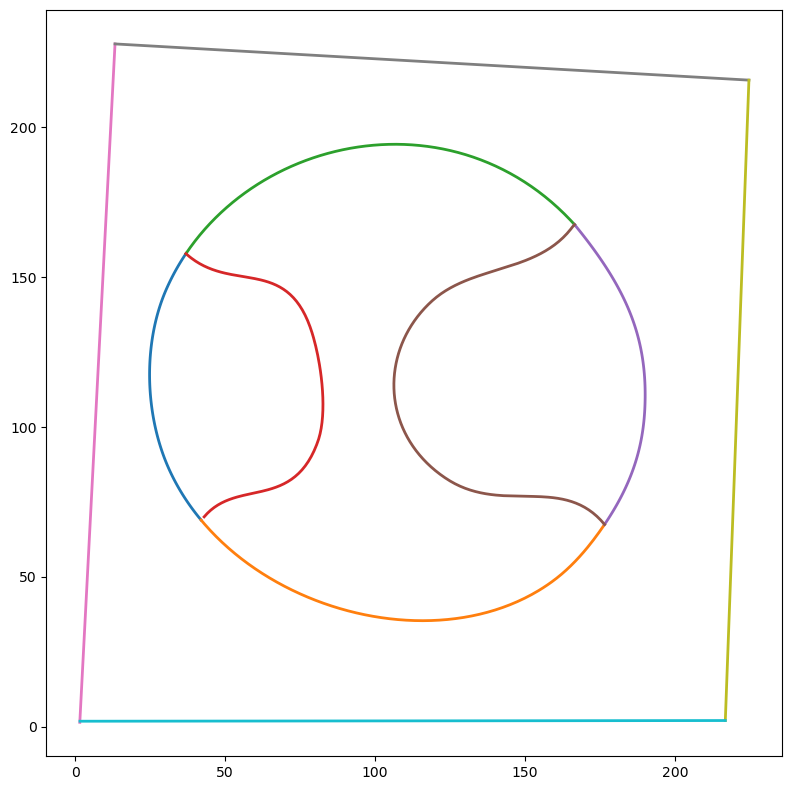

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

# Define colors for plotting
COLORS = ['Black']

# Read CSV data
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = [npXYs[npXYs[:, 0] == j][:, 1:] for j in np.unique(npXYs[:, 0])]
        path_XYs.append(XYs)
    return path_XYs

# Plot functions
def plot(paths_XYs, colors=COLORS):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Simplify Polyline
def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

# Determine if a polyline is a straight line
def is_straight_line(polyline, curvature_threshold=0.01):
    dx_dt = np.gradient(polyline[:, 0])
    dy_dt = np.gradient(polyline[:, 1])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    return np.mean(curvature) < curvature_threshold

# Fit ellipse to points
def fit_ellipse(x, y):
    def ellipse(x, y, x0, y0, a, b, theta):
        x_r = (x - x0) * np.cos(theta) + (y - y0) * np.sin(theta)
        y_r = -(x - x0) * np.sin(theta) + (y - y0) * np.cos(theta)
        return (x_r / a)**2 + (y_r / b)**2 - 1

    def fit_func(params):
        return ellipse(x, y, *params)

    x_center = np.mean(x)
    y_center = np.mean(y)
    a = np.max(x) - np.min(x)
    b = np.max(y) - np.min(y)
    if a < b:
        a, b = b, a
    p0 = [x_center, y_center, a / 2, b / 2, 0]
    bounds = [(None, None), (None, None), (0, None), (0, None), (-np.pi, np.pi)]
    result = optimize.least_squares(fit_func, p0, bounds=bounds, method='trf')
    
    return result.x

# Check if a polyline is a circle or ellipse
def is_circle_or_ellipse(polyline, threshold=0.1):
    x, y = polyline[:, 0], polyline[:, 1]
    try:
        params = fit_ellipse(x, y)
        residuals = np.abs(ellipse(x, y, *params))
        return np.mean(residuals) < threshold
    except:
        return False

# Convert detected shapes to Bézier curves
def bezier_line(start, end):
    return np.array([start, start * 2/3 + end * 1/3, start * 1/3 + end * 2/3, end])

def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    
    return np.column_stack((x, y))

# Convert detected shapes to cubic Bézier curves
def cubic_bezier_curve(P0, P1, P2, P3, num_points=100):
    t = np.linspace(0, 1, num_points)[:, None]  # Making t a column vector for broadcasting
    B_t = (1-t)**3 * P0 + 3*(1-t)**2 * t * P1 + 3*(1-t) * t**2 * P2 + t**3 * P3
    return B_t

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        return cubic_bezier_curve(polyline[0], polyline[0] * 2/3 + polyline[-1] * 1/3, polyline[0] * 1/3 + polyline[-1] * 2/3, polyline[-1])
    elif is_circle_or_ellipse(polyline):
        params = fit_ellipse(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    else:
        # For now, return the simplified polyline itself
        return polyline

def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for bezier_curve in bezier_curves:
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Main Execution
def main(csv_path):
    paths_XYs = read_csv(csv_path)
    bezier_curves = [convert_to_bezier(polyline) for path in paths_XYs for polyline in path]
    plot_bezier(bezier_curves)

# Example usage
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv"
main(csv_path)


In [33]:
import numpy as np
import matplotlib.pyplot as plt

def reflect_points(points, line='y'):
    if line == 'y':
        reflected_points = np.copy(points)
        reflected_points[:, 0] = -reflected_points[:, 0]
    elif line == 'x':
        reflected_points = np.copy(points)
        reflected_points[:, 1] = -reflected_points[:, 1]
    else:
        # For diagonal lines, y = x or y = -x
        if line == 'y=x':
            reflected_points = np.copy(points)
            reflected_points = reflected_points[:, ::-1]
        elif line == 'y=-x':
            reflected_points = np.copy(points)
            reflected_points[:, 0] = -reflected_points[:, 0]
            reflected_points[:, 1] = -reflected_points[:, 1]
            reflected_points = reflected_points[:, ::-1]
    return reflected_points

def check_symmetry(original_points, reflected_points):
    # Check if the reflected points match the original points
    return np.allclose(np.sort(original_points, axis=0), np.sort(reflected_points, axis=0))

def identify_symmetry(points):
    lines_of_symmetry = []
    for line in ['y', 'x', 'y=x', 'y=-x']:
        reflected_points = reflect_points(points, line=line)
        if check_symmetry(points, reflected_points):
            lines_of_symmetry.append(line)
    return lines_of_symmetry

# Example usage
points = np.array([[1, 2], [3, 4], [5, 6], [-1, 2], [-3, 4], [-5, 6]])  # Replace this with your points
symmetry_lines = identify_symmetry(points)
print(f"Symmetry detected along: {symmetry_lines}")


Symmetry detected along: ['y']


Detected Symmetries: []


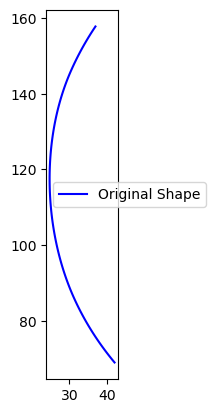

Detected Symmetries: []


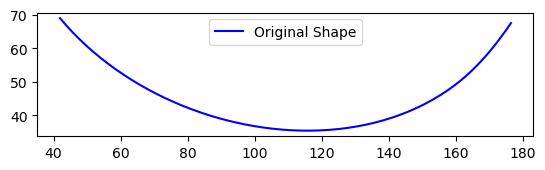

Detected Symmetries: []


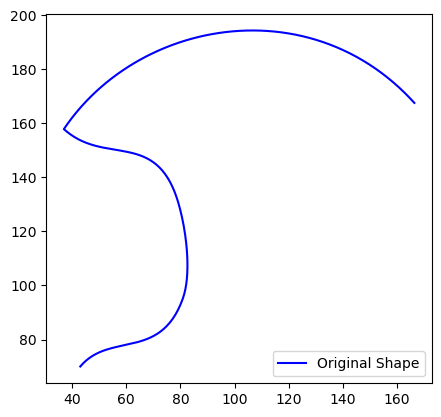

Detected Symmetries: []


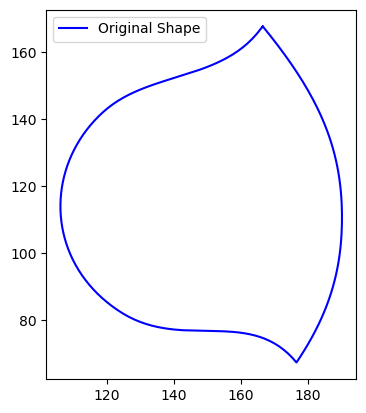

Detected Symmetries: []


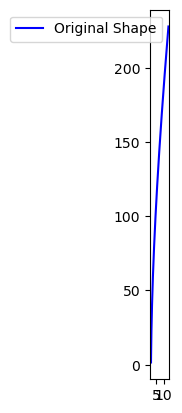

Detected Symmetries: []


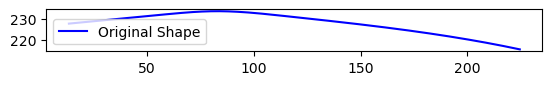

Detected Symmetries: []


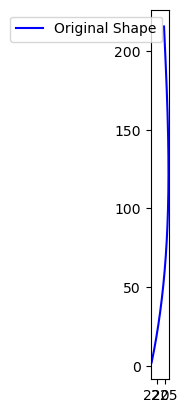

Detected Symmetries: []


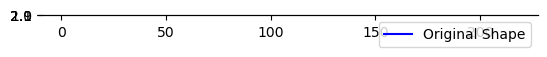

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def reflect_points(points, axis):
    """
    Reflect points over a specified axis.
    Axis is a tuple (x, y) where x and y can be 'horizontal', 'vertical', or 'diagonal'.
    """
    reflected_points = []
    if axis == 'horizontal':
        for point in points:
            reflected_points.append([point[0], -point[1]])
    elif axis == 'vertical':
        for point in points:
            reflected_points.append([-point[0], point[1]])
    elif axis == 'diagonal':
        for point in points:
            reflected_points.append([point[1], point[0]])
    return np.array(reflected_points)

def check_symmetry(original_points, reflected_points, tolerance=1e-6):
    """
    Check if the original points are approximately equal to the reflected points.
    """
    if len(original_points) != len(reflected_points):
        return False
    distances = np.linalg.norm(original_points - reflected_points, axis=1)
    return np.all(distances < tolerance)

def detect_symmetry(points):
    """
    Detect if the shape represented by points has horizontal, vertical, or diagonal symmetry.
    """
    points = np.array(points)
    horizontal_reflected = reflect_points(points, 'horizontal')
    vertical_reflected = reflect_points(points, 'vertical')
    diagonal_reflected = reflect_points(points, 'diagonal')
    
    symmetries = []
    
    if check_symmetry(points, horizontal_reflected):
        symmetries.append('horizontal')
    if check_symmetry(points, vertical_reflected):
        symmetries.append('vertical')
    if check_symmetry(points, diagonal_reflected):
        symmetries.append('diagonal')
    
    return symmetries

def plot_symmetry(points, symmetries):
    """
    Plot the shape and its symmetry lines.
    """
    points = np.array(points)
    fig, ax = plt.subplots()
    ax.plot(points[:, 0], points[:, 1], 'b-', label='Original Shape')

    for sym in symmetries:
        if sym == 'horizontal':
            ax.axhline(y=np.mean(points[:, 1]), color='r', linestyle='--', label='Horizontal Symmetry')
        elif sym == 'vertical':
            ax.axvline(x=np.mean(points[:, 0]), color='g', linestyle='--', label='Vertical Symmetry')
        elif sym == 'diagonal':
            ax.plot([min(points[:, 0]), max(points[:, 0])], [min(points[:, 1]), max(points[:, 1])], 'm--', label='Diagonal Symmetry (45°)')
    
    ax.set_aspect('equal')
    ax.legend()
    plt.show()

# Example usage
def main(csv_path):
    paths_XYs = read_csv(csv_path)
    for path in paths_XYs:
        for polyline in path:
            symmetries = detect_symmetry(polyline)
            print(f"Detected Symmetries: {symmetries}")
            plot_symmetry(polyline, symmetries)

# Example usage
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag1.csv"
main(csv_path)


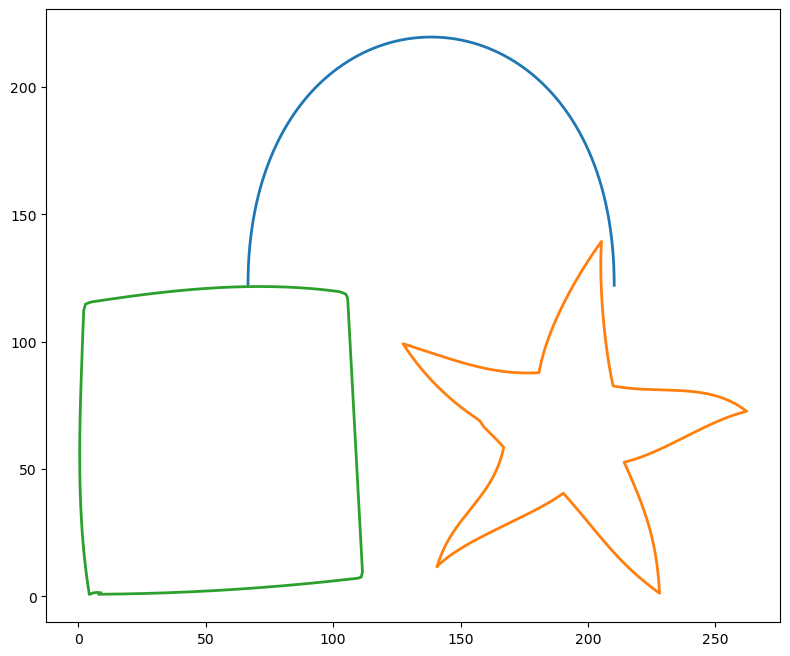

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

# Define colors for plotting
COLORS = ['Black', 'Red', 'Green', 'Blue']

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = [npXYs[npXYs[:, 0] == j][:, 1:] for j in np.unique(npXYs[:, 0])]
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, colors=COLORS):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

def is_straight_line(polyline, curvature_threshold=0.01):
    dx_dt = np.gradient(polyline[:, 0])
    dy_dt = np.gradient(polyline[:, 1])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    return np.mean(curvature) < curvature_threshold

def fit_circle(x, y):
    A = np.c_[x, y, np.ones(x.shape[0])]
    B = x**2 + y**2
    C, _, _, _ = np.linalg.lstsq(A, B, rcond=None)
    x0, y0, c = C
    r = np.sqrt(c + x0**2 + y0**2)
    return x0, y0, r

def is_circle(polyline, threshold=0.1):
    x, y = polyline[:, 0], polyline[:, 1]
    try:
        x0, y0, r = fit_circle(x, y)
        distances = np.sqrt((x - x0)**2 + (y - y0)**2)
        return np.mean(np.abs(distances - r)) < threshold
    except:
        return False

def is_square(polyline, threshold=0.1):
    def angle_between(p1, p2):
        return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

    def is_approx_equal(a, b, tol=0.1):
        return np.abs(a - b) < tol

    angles = []
    for i in range(len(polyline)):
        p1 = polyline[i]
        p2 = polyline[(i + 1) % len(polyline)]
        angles.append(angle_between(p1, p2))
    
    angles = np.array(angles)
    diff_angles = np.diff(np.sort(np.abs(angles - angles[0])))
    return np.all(diff_angles < threshold)

def is_star(polyline, num_points=5, angle_threshold=0.1):
    def compute_angles(points):
        angles = []
        center = np.mean(points, axis=0)
        for point in points:
            angle = np.arctan2(point[1] - center[1], point[0] - center[0])
            angles.append(angle)
        return np.sort(np.array(angles))
    
    angles = compute_angles(polyline)
    angle_diffs = np.diff(angles)
    angle_diffs = np.concatenate([angle_diffs, [2 * np.pi - angles[-1] + angles[0]]])
    
    return np.all(np.abs(angle_diffs - 2 * np.pi / num_points) < angle_threshold)

def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return np.column_stack((x, y))

def cubic_bezier_curve(P0, P1, P2, P3, num_points=100):
    t = np.linspace(0, 1, num_points)[:, None]  
    B_t = (1-t)**3 * P0 + 3*(1-t)**2 * t * P1 + 3*(1-t) * t**2 * P2 + t**3 * P3
    return B_t

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        return cubic_bezier_curve(polyline[0], polyline[0] * 2/3 + polyline[-1] * 1/3, polyline[0] * 1/3 + polyline[-1] * 2/3, polyline[-1])
    elif is_circle(polyline):
        params = fit_circle(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    elif is_square(polyline):
        # Regularize the polyline to a square
        # Simplified approach: fit a bounding box
        min_x, min_y = np.min(polyline, axis=0)
        max_x, max_y = np.max(polyline, axis=0)
        square = np.array([[min_x, min_y],
                           [min_x, max_y],
                           [max_x, max_y],
                           [max_x, min_y],
                           [min_x, min_y]])
        return cubic_bezier_curve(square[0], square[1], square[2], square[3])
    elif is_star(polyline):
        # Regularize the polyline to a star
        num_points = 5
        angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
        radius = np.max(np.linalg.norm(polyline - np.mean(polyline, axis=0), axis=1))
        star = np.array([[radius * np.cos(a), radius * np.sin(a)] for a in angles])
        return star
    else:
        return polyline

def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for bezier_curve in bezier_curves:
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def main(csv_path):
    paths_XYs = read_csv(csv_path)
    bezier_curves = [convert_to_bezier(polyline) for path in paths_XYs for polyline in path]
    plot_bezier(bezier_curves)

# Example usage
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\isolated.csv"
main(csv_path)


In [39]:
    import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

# Define colors for plotting
COLORS = ['Black', 'Red', 'Green', 'Blue']

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = [npXYs[npXYs[:, 0] == j][:, 1:] for j in np.unique(npXYs[:, 0])]
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, colors=COLORS):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

def is_straight_line(polyline, curvature_threshold=0.01):
    dx_dt = np.gradient(polyline[:, 0])
    dy_dt = np.gradient(polyline[:, 1])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    return np.mean(curvature) < curvature_threshold

def fit_circle(x, y):
    def circle(x, y, x0, y0, r):
        return (x - x0)**2 + (y - y0)**2 - r**2

    x_center = np.mean(x)
    y_center = np.mean(y)
    r_initial = np.mean(np.sqrt((x - x_center)**2 + (y - y_center)**2))
    
    p0 = [x_center, y_center, r_initial]
    result = optimize.least_squares(lambda p: circle(x, y, *p), p0)
    return result.x

def is_circle(polyline, threshold=0.1):
    x, y = polyline[:, 0], polyline[:, 1]
    try:
        x0, y0, r = fit_circle(x, y)
        distances = np.sqrt((x - x0)**2 + (y - y0)**2)
        return np.mean(np.abs(distances - r)) < threshold
    except Exception as e:
        print(f"Circle fitting error: {e}")
        return False

def is_square(polyline, threshold=0.1):
    def angle_between(p1, p2):
        return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

    def is_approx_equal(a, b, tol=0.1):
        return np.abs(a - b) < tol

    angles = []
    for i in range(len(polyline)):
        p1 = polyline[i]
        p2 = polyline[(i + 1) % len(polyline)]
        angles.append(angle_between(p1, p2))
    
    angles = np.array(angles)
    diff_angles = np.diff(np.sort(np.abs(angles - angles[0])))
    return np.all(diff_angles < threshold)

def is_star(polyline, num_points=5, angle_threshold=0.1):
    def compute_angles(points):
        angles = []
        center = np.mean(points, axis=0)
        for point in points:
            angle = np.arctan2(point[1] - center[1], point[0] - center[0])
            angles.append(angle)
        return np.sort(np.array(angles))
    
    angles = compute_angles(polyline)
    angle_diffs = np.diff(angles)
    angle_diffs = np.concatenate([angle_diffs, [2 * np.pi - angles[-1] + angles[0]]])
    
    return np.all(np.abs(angle_diffs - 2 * np.pi / num_points) < angle_threshold)

def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return np.column_stack((x, y))

def cubic_bezier_curve(P0, P1, P2, P3, num_points=100):
    t = np.linspace(0, 1, num_points)[:, None]  
    B_t = (1-t)**3 * P0 + 3*(1-t)**2 * t * P1 + 3*(1-t) * t**2 * P2 + t**3 * P3
    return B_t

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        print("Straight line detected")
        return cubic_bezier_curve(polyline[0], polyline[0] * 2/3 + polyline[-1] * 1/3, polyline[0] * 1/3 + polyline[-1] * 2/3, polyline[-1])
    elif is_circle(polyline):
        print("Circle detected")
        params = fit_circle(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    elif is_square(polyline):
        print("Square detected")
        min_x, min_y = np.min(polyline, axis=0)
        max_x, max_y = np.max(polyline, axis=0)
        square = np.array([[min_x, min_y],
                           [min_x, max_y],
                           [max_x, max_y],
                           [max_x, min_y],
                           [min_x, min_y]])
        return cubic_bezier_curve(square[0], square[1], square[2], square[3])
    elif is_star(polyline):
        print("Star detected")
        num_points = 5
        angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
        radius = np.max(np.linalg.norm(polyline - np.mean(polyline, axis=0), axis=1))
        star = np.array([[radius * np.cos(a), radius * np.sin(a)] for a in angles])
        return star
    else:
        print("No simple shape detected")
        return polyline

def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for bezier_curve in bezier_curves:
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def main(csv_path):
    paths_XYs = read_csv(csv_path)
    bezier_curves = [convert_to_bezier(polyline) for path in paths_XYs for polyline in path]
    plot_bezier(bezier_curves)

# Example usage
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\isolated.csv"
main(csv_path)


IndentationError: expected an indented block after function definition on line 9 (1724238544.py, line 10)

Square detected
No simple shape detected
No simple shape detected


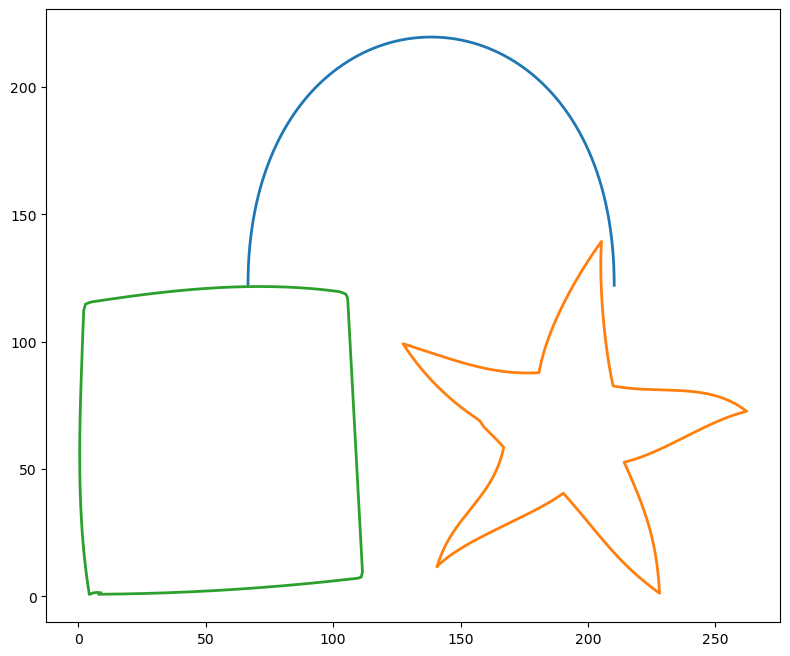

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

# Define colors for plotting
COLORS = ['Black', 'Red', 'Green', 'Blue']

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = [npXYs[npXYs[:, 0] == j][:, 1:] for j in np.unique(npXYs[:, 0])]
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, colors=COLORS):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

def is_straight_line(polyline, curvature_threshold=0.01):
    dx_dt = np.gradient(polyline[:, 0])
    dy_dt = np.gradient(polyline[:, 1])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    return np.mean(curvature) < curvature_threshold

def fit_circle(x, y):
    def circle(x, y, x0, y0, r):
        return (x - x0)**2 + (y - y0)**2 - r**2

    x_center = np.mean(x)
    y_center = np.mean(y)
    r_initial = np.mean(np.sqrt((x - x_center)**2 + (y - y_center)**2))
    
    p0 = [x_center, y_center, r_initial]
    result = optimize.least_squares(lambda p: circle(x, y, *p), p0)
    return result.x

def is_circle(polyline, threshold=0.1):
    x, y = polyline[:, 0], polyline[:, 1]
    try:
        x0, y0, r = fit_circle(x, y)
        distances = np.sqrt((x - x0)**2 + (y - y0)**2)
        return np.mean(np.abs(distances - r)) < threshold
    except Exception as e:
        print(f"Circle fitting error: {e}")
        return False

def is_square(polyline, threshold=0.1):
    def angle_between(p1, p2):
        return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

    def is_approx_equal(a, b, tol=0.1):
        return np.abs(a - b) < tol

    angles = []
    for i in range(len(polyline)):
        p1 = polyline[i]
        p2 = polyline[(i + 1) % len(polyline)]
        angles.append(angle_between(p1, p2))
    
    angles = np.array(angles)
    diff_angles = np.diff(np.sort(np.abs(angles - angles[0])))
    return np.all(diff_angles < threshold)

def is_star(polyline, num_points=5, angle_threshold=0.1):
    def compute_angles(points):
        angles = []
        center = np.mean(points, axis=0)
        for point in points:
            angle = np.arctan2(point[1] - center[1], point[0] - center[0])
            angles.append(angle)
        return np.sort(np.array(angles))
    
    angles = compute_angles(polyline)
    angle_diffs = np.diff(angles)
    angle_diffs = np.concatenate([angle_diffs, [2 * np.pi - angles[-1] + angles[0]]])
    
    return np.all(np.abs(angle_diffs - 2 * np.pi / num_points) < angle_threshold)

def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return np.column_stack((x, y))

def cubic_bezier_curve(P0, P1, P2, P3, num_points=100):
    t = np.linspace(0, 1, num_points)[:, None]  
    B_t = (1-t)**3 * P0 + 3*(1-t)**2 * t * P1 + 3*(1-t) * t**2 * P2 + t**3 * P3
    return B_t

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        print("Straight line detected")
        return cubic_bezier_curve(polyline[0], polyline[0] * 2/3 + polyline[-1] * 1/3, polyline[0] * 1/3 + polyline[-1] * 2/3, polyline[-1])
    elif is_circle(polyline):
        print("Circle detected")
        params = fit_circle(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    elif is_square(polyline):
        print("Square detected")
        min_x, min_y = np.min(polyline, axis=0)
        max_x, max_y = np.max(polyline, axis=0)
        square = np.array([[min_x, min_y],
                           [min_x, max_y],
                           [max_x, max_y],
                           [max_x, min_y],
                           [min_x, min_y]])
        return cubic_bezier_curve(square[0], square[1], square[2], square[3])
    elif is_star(polyline):
        print("Star detected")
        num_points = 5
        angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
        radius = np.max(np.linalg.norm(polyline - np.mean(polyline, axis=0), axis=1))
        star = np.array([[radius * np.cos(a), radius * np.sin(a)] for a in angles])
        return star
    else:
        print("No simple shape detected")
        return polyline

def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for bezier_curve in bezier_curves:
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def main(csv_path):
    paths_XYs = read_csv(csv_path)
    bezier_curves = [convert_to_bezier(polyline) for path in paths_XYs for polyline in path]
    plot_bezier(bezier_curves)

# Example usage
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\isolated.csv"
main(csv_path)


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

# Function definitions (same as before)
def bernstein_poly(i, n, t):
    return comb(n, i) * (t**(i)) * ((1-t)**(n-i))

def bezier_curve(points, num=200):
    n = len(points) - 1
    t = np.linspace(0, 1, num)
    curve = np.zeros((num, 2))
    for i in range(n + 1):
        curve += np.outer(bernstein_poly(i, n, t), points[i])
    return curve

# Read the CSV file
file_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\isolated.csv"
df = pd.read_csv(file_path)

# Assuming the CSV has 'x' and 'y' columns
points = df[['x', 'y']].values

# Generate Bézier curve
curve = bezier_curve(points)

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(curve[:, 0], curve[:, 1], 'b-', label='Bézier Curve')
plt.plot(points[:, 0], points[:, 1], 'ro', label='Control Points')
plt.legend()
plt.title('Regularized Shape with Bézier Curve')
plt.grid(True)
plt.axis('equal')
plt.show()

KeyError: "None of [Index(['x', 'y'], dtype='object')] are in the [columns]"

In [42]:
import pandas as pd

file_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\isolated.csv"
df = pd.read_csv(file_path)

print(df.head())
print("\nColumns:", df.columns)

   0.000000000000000000e+00  0.000000000000000000e+00.1  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   

   1.091429977416992188e+02  1.255800018310546875e+02  
0                110.157478                125.495781  
1                111.171944                125.403984  
2                112.186386                125.305222  
3                113.200790                125.200111  
4                114.215172                125.089264  

Columns: Index(['0.000000000000000000e+00', '0.000000000000000000e+00.1',
       '1.091429977416992188e+02', '1.255800018310546875e+02'],
      dtype='object')


C:\Users\Welcome\AppData\Local\Temp\ipykernel_4636\1316607852.py:7: RuntimeWarning: invalid value encountered in multiply
  return comb(n, i) * (t**(i)) * ((1-t)**(n-i))
C:\Users\Welcome\anaconda3\Lib\site-packages\numpy\core\numeric.py:925: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


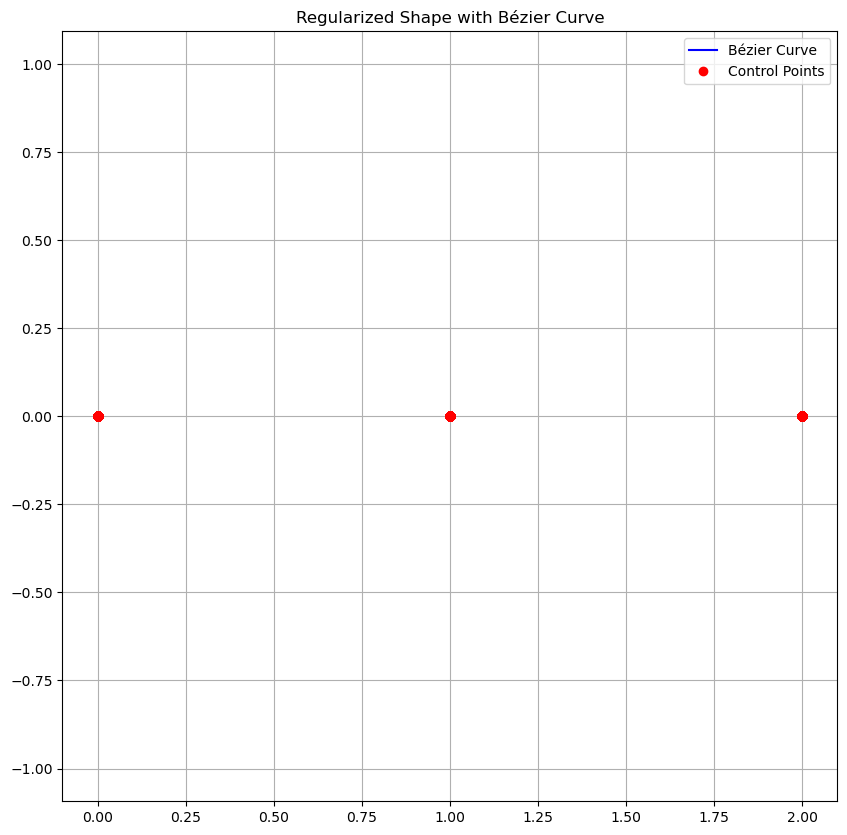

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

def bernstein_poly(i, n, t):
    return comb(n, i) * (t**(i)) * ((1-t)**(n-i))

def bezier_curve(points, num=200):
    n = len(points) - 1
    t = np.linspace(0, 1, num)
    curve = np.zeros((num, 2))
    for i in range(n + 1):
        curve += np.outer(bernstein_poly(i, n, t), points[i])
    return curve

# Read the CSV file
file_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\isolated.csv"
df = pd.read_csv(file_path)

# Assuming the first two columns are x and y coordinates
points = df.iloc[:, :2].values

# Generate Bézier curve
curve = bezier_curve(points)

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(curve[:, 0], curve[:, 1], 'b-', label='Bézier Curve')
plt.plot(points[:, 0], points[:, 1], 'ro', label='Control Points')
plt.legend()
plt.title('Regularized Shape with Bézier Curve')
plt.grid(True)
plt.axis('equal')
plt.show()

DataFrame shape: (963, 4)

First few rows:
   0.000000000000000000e+00  0.000000000000000000e+00.1  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   

   1.235599975585937500e+02  4.519999980926513672e+00  
0                121.641998                  4.886000  
1                120.646271                  5.209438  
2                119.650269                  5.531996  
3                118.653999                  5.853729  
4                117.657494                  6.174689  

Column names: ['0.000000000000000000e+00', '0.000000000000000000e+00.1', '1.235599975585937500e+02', '4.519999980926513672e+00']

Number of points: 963
First few points:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


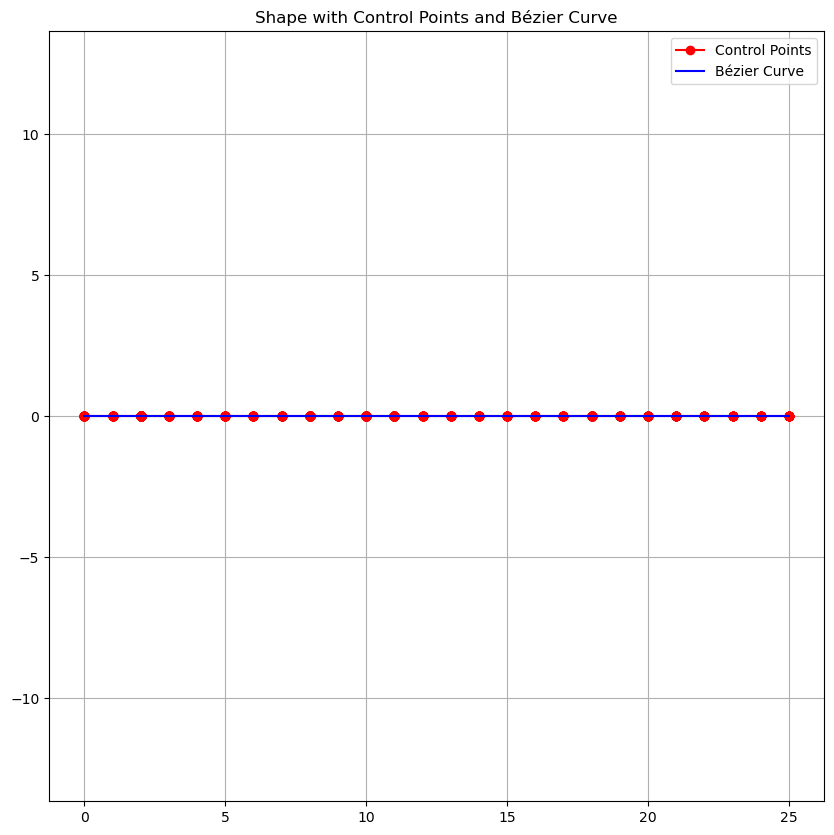

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

def bernstein_poly(i, n, t):
    return comb(n, i) * (t**i) * ((1-t)**(n-i))

def bezier_curve(points, num=200):
    n = len(points) - 1
    t = np.linspace(0, 1, num)
    curve = np.zeros((num, 2))
    for i in range(n + 1):
        curve += np.outer(bernstein_poly(i, n, t), points[i])
    return curve

# Read the CSV file
file_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag2.csv"
df = pd.read_csv(file_path)

# Print information about the data
print("DataFrame shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:", df.columns.tolist())

# Assuming the first two columns are x and y coordinates
points = df.iloc[:, :2].values

print("\nNumber of points:", len(points))
print("First few points:")
print(points[:5])

# Generate Bézier curve only if there are enough points
if len(points) > 2:
    curve = bezier_curve(points)
else:
    curve = points  # Just use the original points if not enough for a curve

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(points[:, 0], points[:, 1], 'ro-', label='Control Points')
if len(points) > 2:
    plt.plot(curve[:, 0], curve[:, 1], 'b-', label='Bézier Curve')
plt.legend()
plt.title('Shape with Control Points' + (' and Bézier Curve' if len(points) > 2 else ''))
plt.grid(True)
plt.axis('equal')
plt.show()

DataFrame shape: (1391, 4)

First few rows:
   0.000000000000000000e+00  0.000000000000000000e+00.1  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   

   1.091429977416992188e+02  1.255800018310546875e+02  
0                110.157478                125.495781  
1                111.171944                125.403984  
2                112.186386                125.305222  
3                113.200790                125.200111  
4                114.215172                125.089264  

Column names: ['0.000000000000000000e+00', '0.000000000000000000e+00.1', '1.091429977416992188e+02', '1.255800018310546875e+02']

Number of points: 1391
All points:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [2. 0.]
 [2. 0.]
 [2. 0.]]


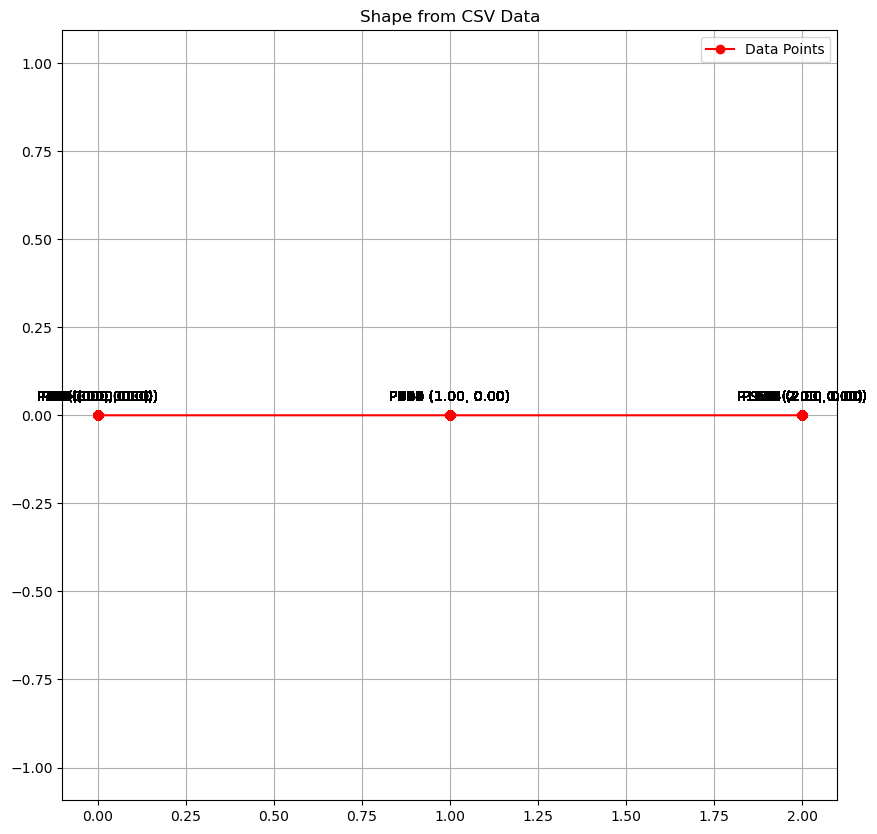


Distances between consecutive points:
Distance between P1 and P2: 0.00
Distance between P2 and P3: 0.00
Distance between P3 and P4: 0.00
Distance between P4 and P5: 0.00
Distance between P5 and P6: 0.00
Distance between P6 and P7: 0.00
Distance between P7 and P8: 0.00
Distance between P8 and P9: 0.00
Distance between P9 and P10: 0.00
Distance between P10 and P11: 0.00
Distance between P11 and P12: 0.00
Distance between P12 and P13: 0.00
Distance between P13 and P14: 0.00
Distance between P14 and P15: 0.00
Distance between P15 and P16: 0.00
Distance between P16 and P17: 0.00
Distance between P17 and P18: 0.00
Distance between P18 and P19: 0.00
Distance between P19 and P20: 0.00
Distance between P20 and P21: 0.00
Distance between P21 and P22: 0.00
Distance between P22 and P23: 0.00
Distance between P23 and P24: 0.00
Distance between P24 and P25: 0.00
Distance between P25 and P26: 0.00
Distance between P26 and P27: 0.00
Distance between P27 and P28: 0.00
Distance between P28 and P29: 0.0

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
file_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\isolated.csv"
df = pd.read_csv(file_path)

# Print information about the data
print("DataFrame shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:", df.columns.tolist())

# Assuming the first two columns are x and y coordinates
points = df.iloc[:, :2].values

print("\nNumber of points:", len(points))
print("All points:")
print(points)

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(points[:, 0], points[:, 1], 'ro-', label='Data Points')
plt.legend()
plt.title('Shape from CSV Data')
plt.grid(True)
plt.axis('equal')

# Add point labels
for i, (x, y) in enumerate(points):
    plt.annotate(f'P{i+1} ({x:.2f}, {y:.2f})', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

# Calculate and print additional information
distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
print("\nDistances between consecutive points:")
for i, d in enumerate(distances):
    print(f"Distance between P{i+1} and P{i+2}: {d:.2f}")

# Check if points are collinear
def are_collinear(p1, p2, p3):
    return np.abs(np.cross(p2-p1, p3-p1)) < 1e-8

collinear = are_collinear(points[0], points[1], points[2])
print(f"\nAre the points collinear? {'Yes' if collinear else 'No'}")

In [52]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min

def regularize_curves(paths_XYs):
    regularized_paths = []
    
    for path in paths_XYs:
        # Calculate the convex hull to simplify the shape
        if len(path) > 2:
            hull = ConvexHull(path)
            regularized_path = path[hull.vertices]
        else:
            regularized_path = path
        
        # Optionally, you can fit a Bezier curve or other regularization techniques here
        
        regularized_paths.append(regularized_path)
    
    return regularized_paths

def visualize_regularized_paths(regularized_paths):
    plt.figure(figsize=(8, 8))
    
    for path in regularized_paths:
        plt.plot(path[:, 0], path[:, 1], linewidth=2)
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Regularized Curves")
    plt.show()

# Example usage
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        
        path_XYs.append(XYs)
    
    return path_XYs

# Load your data
paths_XYs = read_csv('C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\isolated.csv')

# Regularize the curves
regularized_paths = regularize_curves(paths_XYs)

# Visualize the results
visualize_regularized_paths(regularized_paths)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2838152830.py, line 51)

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.optimize import leastsq

def load_curves(csv_path):
    return np.genfromtxt(csv_path, delimiter=',')

def fit_circle(points):
    # Fit a circle to the points using least squares
    x = points[:, 0]
    y = points[:, 1]
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_estimate = np.array([x_m, y_m])

    def calc_R(c):
        return np.sqrt((x - c[0]) ** 2 + (y - c[1]) ** 2)

    def f(c):
        return np.sum((calc_R(c) - np.mean(calc_R(c))) ** 2)

    center, _ = leastsq(f, center_estimate)
    radius = np.mean(calc_R(center))
    return center, radius

def fit_ellipse(points):
    # Fit an ellipse to the points (simplified version)
    # More sophisticated methods can be implemented
    # Placeholder for ellipse fitting
    pass

def regularize_shapes(curves):
    regularized_shapes = []
    
    for curve in curves:
        center, radius = fit_circle(curve)
        regularized_shapes.append((center, radius))
        
        # Uncomment to fit ellipses if implemented
        # ellipse_params = fit_ellipse(curve)
        # regularized_shapes.append(ellipse_params)

    return regularized_shapes

def visualize_shapes(curves, regularized_shapes):
    plt.figure(figsize=(8, 8))
    
    for curve in curves:
        plt.plot(curve[:, 0], curve[:, 1], 'b-')
    
    for center, radius in regularized_shapes:
        circle = plt.Circle(center, radius, color='r', fill=False)
        plt.gca().add_artist(circle)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Original Curves and Regularized Shapes")
    plt.show()

# Example usage
curves = load_curves('C:/Users/Welcome/Documents/college/Projects/Curvetopia/problems/isolated.csv')
regularized_shapes = regularize_shapes(curves)
visualize_shapes(curves, regularized_shapes)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Skipping line: 0.000000000000000000e+00,0.000000000000000000e+00,1.091429977416992188e+02,1.255800018310546875e+02
Skipping line: 0.000000000000000000e+00,0.000000000000000000e+00,1.101574783325195312e+02,1.254957809448242188e+02
Skipping line: 0.000000000000000000e+00,0.000000000000000000e+00,1.111719436645507812e+02,1.254039840698242188e+02
Skipping line: 0.000000000000000000e+00,0.000000000000000000e+00,1.121863861083984375e+02,1.253052215576171875e+02
Skipping line: 0.000000000000000000e+00,0.000000000000000000e+00,1.132007904052734375e+02,1.252001113891601562e+02
Skipping line: 0.000000000000000000e+00,0.000000000000000000e+00,1.142151718139648438e+02,1.250892639160156250e+02
Skipping line: 0.000000000000000000e+00,0.000000000000000000e+00,1.152295074462890625e+02,1.249732894897460938e+02
Skipping line: 0.000000000000000000e+00,0.000000000000000000e+00,1.162437973022460938e+02,1.248527908325195312e+02
Skipping line: 0.000000000000000000e+00,0.000000000000000000e+00,1.1725804138183

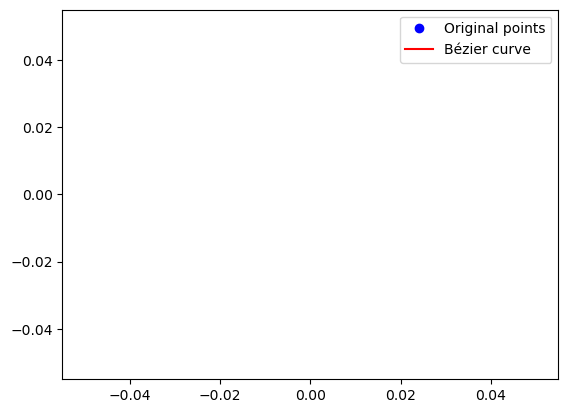

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return binom(n, i) * ( t**(n-i) ) * (1 - t)**i

def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """
    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)
    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals


def read_data(filename):
    points = []
    with open(filename, 'r') as f:
        for line in f:
            values = line.strip().split('\t')
            if len(values) >= 4:  # Check if the line has at least 4 columns
                x = float(values[2])
                y = float(values[3])
                points.append([x, y])
            else:
                print(f"Skipping line: {line.strip()}")  # Print a message if the line is skipped
    return points

def main():
    # Read the data from the file
    filename = r'C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\isolated.csv'
    points = read_data(filename)

    # Fit the Bézier curve
    xvals, yvals = bezier_curve(points)

    # Plot the points and the Bézier curve
    plt.plot([p[0] for p in points], [p[1] for p in points], 'bo', label='Original points')
    plt.plot(xvals, yvals, 'r-', label='Bézier curve')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

# Define colors for plotting
COLORS = ['Black', 'Red', 'Green', 'Blue']

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = [npXYs[npXYs[:, 0] == j][:, 1:] for j in np.unique(npXYs[:, 0])]
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, colors=COLORS):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

def is_straight_line(polyline, curvature_threshold=0.01):
    dx_dt = np.gradient(polyline[:, 0])
    dy_dt = np.gradient(polyline[:, 1])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    return np.mean(curvature) < curvature_threshold

def fit_circle(x, y):
    def circle(x, y, x0, y0, r):
        return (x - x0)**2 + (y - y0)**2 - r**2

    x_center = np.mean(x)
    y_center = np.mean(y)
    r_initial = np.mean(np.sqrt((x - x_center)**2 + (y - y_center)**2))
    
    p0 = [x_center, y_center, r_initial]
    result = optimize.least_squares(lambda p: circle(x, y, *p), p0)
    return result.x

def is_circle(polyline, threshold=0.1):
    x, y = polyline[:, 0], polyline[:, 1]
    try:
        x0, y0, r = fit_circle(x, y)
        distances = np.sqrt((x - x0)**2 + (y - y0)**2)
        return np.mean(np.abs(distances - r)) < threshold
    except Exception as e:
        print(f"Circle fitting error: {e}")
        return False

def is_square(polyline, threshold=0.1):
    def angle_between(p1, p2):
        return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

    def is_approx_equal(a, b, tol=0.1):
        return np.abs(a - b) < tol

    angles = []
    for i in range(len(polyline)):
        p1 = polyline[i]
        p2 = polyline[(i + 1) % len(polyline)]
        angles.append(angle_between(p1, p2))
    
    angles = np.array(angles)
    diff_angles = np.diff(np.sort(np.abs(angles - angles[0])))
    return np.all(diff_angles < threshold)

def is_star(polyline, num_points=5, angle_threshold=0.1):
    def compute_angles(points):
        angles = []
        center = np.mean(points, axis=0)
        for point in points:
            angle = np.arctan2(point[1] - center[1], point[0] - center[0])
            angles.append(angle)
        return np.sort(np.array(angles))
    
    angles = compute_angles(polyline)
    angle_diffs = np.diff(angles)
    angle_diffs = np.concatenate([angle_diffs, [2 * np.pi - angles[-1] + angles[0]]])
    
    return np.all(np.abs(angle_diffs - 2 * np.pi / num_points) < angle_threshold)

def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return np.column_stack((x, y))

def cubic_bezier_curve(P0, P1, P2, P3, num_points=100):
    t = np.linspace(0, 1, num_points)[:, None]  
    B_t = (1-t)**3 * P0 + 3*(1-t)**2 * t * P1 + 3*(1-t) * t**2 * P2 + t**3 * P3
    return B_t

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        print("Straight line detected")
        return cubic_bezier_curve(polyline[0], polyline[0] * 2/3 + polyline[-1] * 1/3, polyline[0] * 1/3 + polyline[-1] * 2/3, polyline[-1])
    elif is_circle(polyline):
        print("Circle detected")
        params = fit_circle(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    elif is_square(polyline):
        print("Square detected")
        min_x, min_y = np.min(polyline, axis=0)
        max_x, max_y = np.max(polyline, axis=0)
        square = np.array([[min_x, min_y],
                           [min_x, max_y],
                           [max_x, max_y],
                           [max_x, min_y],
                           [min_x, min_y]])
        return cubic_bezier_curve(square[0], square[1], square[2], square[3])
    elif is_star(polyline):
        print("Star detected")
        num_points = 5
        angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
        radius = np.max(np.linalg.norm(polyline - np.mean(polyline, axis=0), axis=1))
        star = np.array([[radius * np.cos(a), radius * np.sin(a)] for a in angles])
        return star
    else:
        print("No simple shape detected")
        return polyline

def reflect_polyline(polyline, axis='vertical'):
    if axis == 'vertical':
        reflected = polyline.copy()
        reflected[:, 0] = -reflected[:, 0]
    elif axis == 'horizontal':
        reflected = polyline.copy()
        reflected[:, 1] = -reflected[:, 1]
    elif axis == 'diagonal':
        reflected = polyline.copy()
        reflected[:, [0, 1]] = reflected[:, [1, 0]]
    return reflected

def check_symmetry(polyline):
    vertical_symmetry = np.allclose(polyline, reflect_polyline(polyline, axis='vertical'), atol=0.1)
    horizontal_symmetry = np.allclose(polyline, reflect_polyline(polyline, axis='horizontal'), atol=0.1)
    diagonal_symmetry = np.allclose(polyline, reflect_polyline(polyline, axis='diagonal'), atol=0.1)
    
    symmetries = {
        'Vertical Symmetry': vertical_symmetry,
        'Horizontal Symmetry': horizontal_symmetry,
        'Diagonal Symmetry': diagonal_symmetry
    }
    return symmetries

def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for bezier_curve in bezier_curves:
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def main(csv_path):
    paths_XYs = read_csv(csv_path)
    bezier_curves = [convert_to_bezier(polyline) for path in paths_XYs for polyline in path]
    
    for curve in bezier_curves:
        symmetries = check_symmetry(curve)
        for symmetry_type, is_symmetric in symmetries.items():
            if is_symmetric:
                print(f"{symmetry_type} detected.")
    
    plot_bezier
csv_file_path = r'C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv'

# Run the main function with the CSV file path
main(csv_file_path)

Circle detected


ValueError: not enough values to unpack (expected 5, got 3)

In [16]:
import numpy as np
from scipy.optimize import leastsq
import matplotlib.pyplot as plt

def read_csv(csv_path):
    return np.genfromtxt(csv_path, delimiter=',')

def is_straight_line(polyline):
    return len(polyline) == 2

def is_circle(polyline):
    # Check if the points form a circle
    return len(polyline) >= 3 and np.allclose(polyline[0], polyline[-1], atol=1e-2)

def is_ellipse(polyline):
    # Placeholder check for ellipse
    return len(polyline) >= 5 and np.allclose(polyline[0], polyline[-1], atol=1e-2)

def is_square(polyline):
    # Check if the points form a square
    if len(polyline) != 5:  # A square's polyline should have 5 points (first == last)
        return False
    return True

def fit_circle(x, y):
    x_m = np.mean(x)
    y_m = np.mean(y)
    u = x - x_m
    v = y - y_m
    Suu = np.sum(u**2)
    Suv = np.sum(u*v)
    Svv = np.sum(v**2)
    Suuu = np.sum(u**3)
    Suvv = np.sum(u*v**2)
    Svvv = np.sum(v**3)
    Svuu = np.sum(v*u**2)
    A = np.array([[Suu, Suv], [Suv, Svv]])
    b = np.array([Suuu + Suvv, Svvv + Svuu]) / 2.0
    uc, vc = np.linalg.solve(A, b)
    xc_1 = x_m + uc
    yc_1 = y_m + vc
    r = np.mean(np.sqrt((x - xc_1)**2 + (y - yc_1)**2))
    return xc_1, yc_1, r

def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return np.vstack((x, y)).T

def convert_square_to_bezier(polyline):
    # Implement the Bézier conversion logic for squares
    # This is a placeholder logic
    return polyline

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        print("Straight line detected")
        return cubic_bezier_curve(polyline[0], polyline[0] * 2/3 + polyline[-1] * 1/3, polyline[0] * 1/3 + polyline[-1] * 2/3, polyline[-1])
    elif is_circle(polyline):
        print("Circle detected")
        x0, y0, r = fit_circle(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse((x0, y0, r, r, 0))  # Treating circle as an ellipse with equal radii
    elif is_ellipse(polyline):
        print("Ellipse detected")
        params = fit_ellipse(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    elif is_square(polyline):
        print("Square detected")
        return convert_square_to_bezier(polyline)
    else:
        # For now, return the simplified polyline itself
        return polyline

def cubic_bezier_curve(p0, p1, p2, p3, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = (1-t)**3 * p0 + 3 * (1-t)**2 * t * p1 + 3 * (1-t) * t**2 * p2 + t**3 * p3
    return curve

def check_symmetry(bezier_curve):
    # Placeholder function to check for symmetry
    return "Symmetry check placeholder"

def main(csv_path):
    paths_XYs = read_csv(csv_path)
    bezier_curves = [convert_to_bezier(polyline) for path in paths_XYs for polyline in path]

    for curve in bezier_curves:
        symmetries = check_symmetry(curve)
        print(symmetries)

# Update the path with a raw string
csv_file_path = r'C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv'

# Run the main function with the CSV file path
main(csv_file_path)


TypeError: object of type 'numpy.float64' has no len()

In [17]:
import numpy as np
from scipy.optimize import leastsq
import matplotlib.pyplot as plt

def read_csv(csv_path):
    return np.genfromtxt(csv_path, delimiter=',')

def is_straight_line(polyline):
    return polyline.shape[0] == 2  # Check if there are exactly 2 points

def is_circle(polyline):
    return polyline.shape[0] >= 3 and np.allclose(polyline[0], polyline[-1], atol=1e-2)

def is_ellipse(polyline):
    return polyline.shape[0] >= 5 and np.allclose(polyline[0], polyline[-1], atol=1e-2)

def is_square(polyline):
    if polyline.shape[0] != 5:  # A square's polyline should have 5 points (first == last)
        return False
    return True

def fit_circle(x, y):
    x_m = np.mean(x)
    y_m = np.mean(y)
    u = x - x_m
    v = y - y_m
    Suu = np.sum(u**2)
    Suv = np.sum(u*v)
    Svv = np.sum(v**2)
    Suuu = np.sum(u**3)
    Suvv = np.sum(u*v**2)
    Svvv = np.sum(v**3)
    Svuu = np.sum(v*u**2)
    A = np.array([[Suu, Suv], [Suv, Svv]])
    b = np.array([Suuu + Suvv, Svvv + Svuu]) / 2.0
    uc, vc = np.linalg.solve(A, b)
    xc_1 = x_m + uc
    yc_1 = y_m + vc
    r = np.mean(np.sqrt((x - xc_1)**2 + (y - yc_1)**2))
    return xc_1, yc_1, r

def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return np.vstack((x, y)).T

def convert_square_to_bezier(polyline):
    return polyline

def convert_to_bezier(polyline):
    polyline = np.array(polyline).reshape(-1, 2)  # Ensure polyline is reshaped into Nx2 format
    if is_straight_line(polyline):
        print("Straight line detected")
        return cubic_bezier_curve(polyline[0], polyline[0] * 2/3 + polyline[-1] * 1/3, polyline[0] * 1/3 + polyline[-1] * 2/3, polyline[-1])
    elif is_circle(polyline):
        print("Circle detected")
        x0, y0, r = fit_circle(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse((x0, y0, r, r, 0))
    elif is_ellipse(polyline):
        print("Ellipse detected")
        params = fit_ellipse(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    elif is_square(polyline):
        print("Square detected")
        return convert_square_to_bezier(polyline)
    else:
        return polyline

def cubic_bezier_curve(p0, p1, p2, p3, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = (1-t)**3 * p0 + 3 * (1-t)**2 * t * p1 + 3 * (1-t) * t**2 * p2 + t**3 * p3
    return curve

def check_symmetry(bezier_curve):
    return "Symmetry check placeholder"

def main(csv_path):
    data = read_csv(csv_path)
    data = data.reshape(-1, 2)  # Ensure data is reshaped into Nx2 format
    paths_XYs = np.split(data, np.where(np.isnan(data[:, 0]))[0])[:-1]

    bezier_curves = [convert_to_bezier(polyline) for polyline in paths_XYs]

    for curve in bezier_curves:
        symmetries = check_symmetry(curve)
        print(symmetries)

csv_file_path = r'C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv'
main(csv_file_path)


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def read_csv(csv_path):
    data = np.genfromtxt(csv_path, delimiter=',')
    print(f"Data from CSV:\n{data}\n")  # Debugging output
    return data

def is_straight_line(polyline):
    return polyline.shape[0] == 2

def is_circle(polyline):
    return polyline.shape[0] >= 3 and np.allclose(polyline[0], polyline[-1], atol=1e-2)

def is_ellipse(polyline):
    return polyline.shape[0] >= 5 and np.allclose(polyline[0], polyline[-1], atol=1e-2)

def is_square(polyline):
    if polyline.shape[0] != 5:
        return False
    return True

def fit_circle(x, y):
    x_m = np.mean(x)
    y_m = np.mean(y)
    u = x - x_m
    v = y - y_m
    Suu = np.sum(u**2)
    Suv = np.sum(u*v)
    Svv = np.sum(v**2)
    Suuu = np.sum(u**3)
    Suvv = np.sum(u*v**2)
    Svvv = np.sum(v**3)
    Svuu = np.sum(v*u**2)
    A = np.array([[Suu, Suv], [Suv, Svv]])
    b = np.array([Suuu + Suvv, Svvv + Svuu]) / 2.0
    uc, vc = np.linalg.solve(A, b)
    xc_1 = x_m + uc
    yc_1 = y_m + vc
    r = np.mean(np.sqrt((x - xc_1)**2 + (y - yc_1)**2))
    return xc_1, yc_1, r

def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return np.vstack((x, y)).T

def convert_square_to_bezier(polyline):
    return polyline

def convert_to_bezier(polyline):
    polyline = np.array(polyline).reshape(-1, 2)
    print(f"Polyline:\n{polyline}\n")  # Debugging output

    if is_straight_line(polyline):
        print("Straight line detected")
        return cubic_bezier_curve(polyline[0], polyline[0] * 2/3 + polyline[-1] * 1/3, polyline[0] * 1/3 + polyline[-1] * 2/3, polyline[-1])
    elif is_circle(polyline):
        print("Circle detected")
        x0, y0, r = fit_circle(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse((x0, y0, r, r, 0))
    elif is_ellipse(polyline):
        print("Ellipse detected")
        params = fit_ellipse(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    elif is_square(polyline):
        print("Square detected")
        return convert_square_to_bezier(polyline)
    else:
        print("Unrecognized shape")
        return polyline

def cubic_bezier_curve(p0, p1, p2, p3, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = (1-t)**3 * p0 + 3 * (1-t)**2 * t * p1 + 3 * (1-t) * t**2 * p2 + t**3 * p3
    return curve

def check_symmetry(bezier_curve):
    # Add actual symmetry checks here
    print(f"Checking symmetry for curve:\n{bezier_curve}\n")
    return "Symmetry check placeholder"

def main(csv_path):
    data = read_csv(csv_path)
    data = data.reshape(-1, 2)
    paths_XYs = np.split(data, np.where(np.isnan(data[:, 0]))[0])[:-1]

    bezier_curves = [convert_to_bezier(polyline) for polyline in paths_XYs]

    for curve in bezier_curves:
        symmetries = check_symmetry(curve)
        print(f"Symmetries found: {symmetries}\n")

csv_file_path = r'C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv'
main(csv_file_path)


Data from CSV:
[[  0.           0.          41.94200134  68.98000336]
 [  0.           0.          41.25960541  69.81170654]
 [  0.           0.          40.58875275  70.65237427]
 ...
 [  9.           0.         214.76663208   2.10484123]
 [  9.           0.         215.77230835   2.10592055]
 [  9.           0.         216.77799988   2.10700011]]



In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Function to read CSV file
def read_csv(csv_path):
    return np.genfromtxt(csv_path, delimiter=',')

# Function to detect if the polyline is a straight line
def is_straight_line(polyline):
    return len(polyline) == 2

# Function to convert polyline to Bezier curve
def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        print("Straight line detected")
        return cubic_bezier_curve(polyline[0], polyline[0] * 2/3 + polyline[-1] * 1/3, polyline[0] * 1/3 + polyline[-1] * 2/3, polyline[-1])
    # Implement other shape detections here (circle, square, etc.)
    return polyline

# Function to draw cubic Bezier curve
def cubic_bezier_curve(p0, p1, p2, p3, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = (1 - t)**3 * p0 + 3 * (1 - t)**2 * t * p1 + 3 * (1 - t) * t**2 * p2 + t**3 * p3
    return curve

# Function to detect symmetry (stub function)
def check_symmetry(curve):
    # Implement symmetry detection (vertical, horizontal, diagonal)
    pass

# Function to plot the shapes
def plot_shape(original, bezier, title="Shape"):
    plt.figure()
    plt.plot(original[:, 0], original[:, 1], 'bo-', label='Original')
    plt.plot(bezier[:, 0], bezier[:, 1], 'r--', label='Bezier Curve')
    plt.legend()
    plt.title(title)
    plt.show()

# Main function to process the shapes
def main(csv_path):
    paths_XYs = read_csv(csv_path)
    for path in paths_XYs:
        for polyline in path:
            bezier_curve = convert_to_bezier(polyline)
            plot_shape(polyline, bezier_curve, "Regularized Shape")
            symmetries = check_symmetry(bezier_curve)
            # Implement and visualize symmetry detection here

# Path to the CSV file
csv_file_path = r'C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv'

# Run the main function with the CSV file path
main(csv_file_path)


TypeError: object of type 'numpy.float64' has no len()

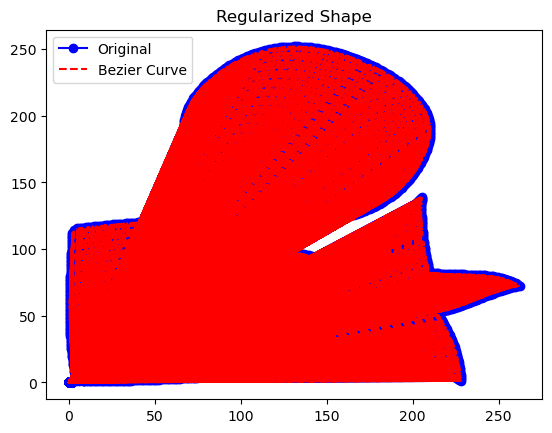

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Function to read CSV file and structure it as a list of polylines
def read_csv(csv_path):
    data = np.genfromtxt(csv_path, delimiter=',')
    return data.reshape(-1, 2)  # Assuming that the CSV contains a flat list of x, y coordinates

# Function to detect if the polyline is a straight line
def is_straight_line(polyline):
    return len(polyline) == 2  # True if there are exactly 2 points

# Function to convert polyline to Bezier curve
def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        print("Straight line detected")
        return cubic_bezier_curve(polyline[0], polyline[0] * 2/3 + polyline[-1] * 1/3, polyline[0] * 1/3 + polyline[-1] * 2/3, polyline[-1])
    # Implement other shape detections here (circle, square, etc.)
    return polyline

# Function to draw cubic Bezier curve
def cubic_bezier_curve(p0, p1, p2, p3, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = (1 - t)**3 * p0 + 3 * (1 - t)**2 * t * p1 + 3 * (1 - t) * t**2 * p2 + t**3 * p3
    return curve

# Function to detect symmetry (stub function)
def check_symmetry(curve):
    # Implement symmetry detection (vertical, horizontal, diagonal)
    pass

# Function to plot the shapes
def plot_shape(original, bezier, title="Shape"):
    plt.figure()
    plt.plot(original[:, 0], original[:, 1], 'bo-', label='Original')
    plt.plot(bezier[:, 0], bezier[:, 1], 'r--', label='Bezier Curve')
    plt.legend()
    plt.title(title)
    plt.show()

# Main function to process the shapes
def main(csv_path):
    paths_XYs = read_csv(csv_path)
    polyline = paths_XYs
    bezier_curve = convert_to_bezier(polyline)
    plot_shape(polyline, bezier_curve, "Regularized Shape")
    symmetries = check_symmetry(bezier_curve)
    # Implement and visualize symmetry detection here

# Path to the CSV file
csv_file_path = r'C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\isolated.csv'

# Run the main function with the CSV file path
main(csv_file_path)
